- First of all, congratulations to all kagglers and thanks to organizers. I have learned a lot from this competition, so I would like to share my solution here. I hope some pepole find new ideas from my solution.
- This notebook is based on the following great notebooks.
  - https://www.kaggle.com/khoongweihao/efficientnets-quantile-regression-inference
  - https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric
  - https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing
  - https://www.kaggle.com/unforgiven/osic-comprehensive-eda

# Imports

In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index
#!conda install -c conda-forge gdcm -y

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=e96413f715755c4bc4487dace9748b2056a3d5e6aeaef294b2b49fde31ae1edd
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=46dc13bbb27ac574ca2529d75d2378b6071b6878958bed3649478bee7ede049c
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
import os
import gc
import cv2
import random
import pydicom
import operator
import typing as tp
import pandas as pd
import numpy as np 
import pymc3 as pm
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
from datetime import datetime
from IPython.display import display

from scipy.stats import describe
from scipy.ndimage import binary_fill_holes
from skimage import measure, morphology
from skimage.filters import threshold_otsu, median
from skimage.segmentation import clear_border
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, TimeSeriesSplit, GroupKFold, GroupShuffleSplit
from optuna.visualization import plot_optimization_history

import optuna
import lightgbm as lgb
import efficientnet.tfkeras as efn
import tensorflow_addons as tfa
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
import tensorflow.keras.activations as activations
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Nadam
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate, DepthwiseConv2D, Maximum, Layer)

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

pd.set_option("max_columns", 100)
pd.set_option('display.max_rows', 150)
seed_everything(42)

In [3]:
config  = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
BAD_IDS = ['ID00011637202177653955184', 'ID00052637202186188008618']

# Linear Decay (based on EfficientNets)

In [5]:
# Define the last 3 and last 6 in order to get solid cv.
def add_last(data, add3=True, add_other=0):
    data["last3"] = False
    if add_other != 0:
        data["last"+str(add_other)] = False
    for patient in data.Patient.unique():
        weeks   = data.query("Patient == @patient & WHERE == 'train'").Weeks
        weeks_3 = sorted(weeks)[-3:]
        weeks_other = sorted(weeks)[-add_other:]
        data.loc[(data.Patient==patient)&(data.Weeks.isin(weeks_3)), "last3"] = True
        if add_other != 0:
            data.loc[(data.Patient==patient)&(data.Weeks.isin(weeks_other)), "last"+str(add_other)] = True
    return data

def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    if df.Sex.values[0] == 'male':
        vector.append(0)
    else:
        vector.append(1)
    if   df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [6]:
# Funnel ReLu(https://arxiv.org/abs/2007.11824)
class FReLU(Layer):
    def __init__(self, kernel_size=3):
        super(FReLU, self).__init__()
        self.conv = DepthwiseConv2D(kernel_size=kernel_size, padding="same")
        self.bn   = BatchNormalization()

    def call(self, inputs):
        x1 = self.conv(inputs)
        x1 = self.bn(x1)
        x  = K.maximum(inputs, x1)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'conv': self.conv,
            'bn': self.bn})
        return config

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def redifine_efn_model(model):
    for i, layer in enumerate(model.layers):
        if i==0:
            input = layer.input
            x     = input
            seblock_on = False
            block_prev = ""
            continue
            
        block_curt = layer.name[:layer.name.find("_")]
        if block_prev != block_curt:
            input_block = x
            
        # Change from current activation to FReLU
        if   -1 < layer.name.find("activation"):
            x = FReLU()(x)
        # SEBLOCKS
        elif -1 < layer.name.find("se"):
            if -1 < layer.name.find("excite"):
                x = layer([x, x_seblock])
                seblock_on = False
            elif -1 < layer.name.find("reduce"):
                layer.activation = activations.linear
                x_seblock = layer(x_seblock)
                x_seblock = FReLU()(x_seblock)
            elif not seblock_on:
                seblock_on = True 
                x_seblock  = layer(x)
            else:
                x_seblock  = layer(x_seblock)
        # Add Layer
        elif -1 < layer.name.find("add"):
            x = layer([x, input_block])
        # Normal Layer
        else:
            x = layer(x)      
        block_prev = block_curt
    return Model(input, x)

def build_model(shape=(512, 512, 1), model_class=None, act=None):
    inp  = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    if act == "FReLU":
        base = redifine_efn_model(base)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x  = Concatenate()([x, x2]) 
    x  = Dropout(0.5)(x) 
    x  = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    return model

In [7]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta  = np.abs(fvc_true - fvc_pred)
    delta  = np.minimum(delta, 1000)
    sq2    = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

def get_img(path, shapes):
    def rescale(img, ri, rs):
        return (img - ri) / (rs * 1000)
    d    = pydicom.dcmread(path)
    img  = d.pixel_array
    img[img <= -1000] = 0
    img  = img.astype(np.int32)
    W, H = img.shape
    if W == H:
        img = rescale(img, d.RescaleIntercept, d.RescaleSlope)
        if W == shapes[0]:
            return img
        else:
            return cv2.resize(img, shapes)
    iimg   = Image.fromarray(img, mode="I")
    left   = (img.shape[1]-512)/2
    right  = (img.shape[1]+512)/2
    top    = (img.shape[0]-512)/2
    bottom = (img.shape[0]+512)/2
    iimg   = iimg.crop((left, top, right, bottom))
    iimg   = iimg.resize(shapes, resample=Image.LANCZOS)
    return rescale(np.array(iimg), d.RescaleIntercept, d.RescaleSlope)

def get_result(models, shapes, vl_p):
    m = [[],[],[],[],[],[],[],[],[]]
    df_results = pd.DataFrame()
    metric = []
    for p in tqdm(vl_p):
        if p in BAD_IDS: continue
        x    = [] 
        tab  = [] 
        path = '../input/osic-pulmonary-fibrosis-progression/train/%s/' % p

        ldir = os.listdir(path)
        ldir = random.sample(ldir, 30) if 30 < len(ldir) else ldir
        for i in ldir:
            x.append(get_img(path + i, shapes))
            tab.append(get_tab(train.loc[train.Patient == p, :])) 
        tab = np.array(tab) 

        percent_true = train.Percent.values[train.Patient == p]
        fvc_true     = train.FVC    .values[train.Patient == p]
        weeks_true   = train.Weeks  .values[train.Patient == p]
        
        x  = np.expand_dims(x, axis=-1)
        for idx, model in enumerate(models):
            _a = model.predict([x, tab])
            for q in range(1, 10):
                a          = np.quantile(_a, q / 10)
                fvc        = a * (weeks_true - weeks_true[0]) + fvc_true[0]
                percent    = percent_true[0] - a * abs(weeks_true - weeks_true[0])
                lll_score  = score(fvc_true, fvc, percent)
                df_results = df_results.append(pd.DataFrame({"model_id":idx, "q":q, "Patient":p, "Weeks":weeks_true, 
                                                             "lll_score":lll_score, "fvc_true":fvc_true, "fvc":fvc, "confidence":percent}))
    metric = df_results.groupby("q", as_index=False).lll_score.mean()
    metric = metric.sort_values(by="q").reset_index(drop=True)
    print(metric)
    if len(np.unique(metric.lll_score))==1:
        q = 5
    else:
        q = (np.argmin(metric.lll_score) + 1)
    df_results = df_results.query("q == @q").reset_index(drop=True)
    q /= 10
    
    sub  = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test, W, FVC = {},{},{},{},{} 
    STD, WEEK = {},{} 
    for p in test.Patient.unique():
        x = []; tab = []; a_test = 0; b_test = 0
        path = '../input/osic-pulmonary-fibrosis-progression/test/%s/' % p
        
        ldir = os.listdir(path)
        ldir = random.sample(ldir, 30) if 30 < len(ldir) else ldir
        for i in ldir:
            x.append(get_img(path + i, shapes)) 
            tab.append(get_tab(test.loc[test.Patient == p, :])) 
            
        tab = np.array(tab) 
        x   = np.expand_dims(x, axis=-1)
        for model in models:
            _a  = model.predict([x, tab]) 
            a   = np.quantile(_a, q)
            a_test    += a 
            b_test    += test.FVC    .values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
            P_test[p]  = test.Percent.values[test.Patient == p] 
            WEEK[p]    = test.Weeks  .values[test.Patient == p]
        A_test[p] = a_test / len(models)
        B_test[p] = b_test / len(models)

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w    = int(w) 
        fvc  = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC']        = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (P_test[p] - A_test[p] * abs(WEEK[p] - w))
        
    return df_results, sub[["Patient_Week","FVC","Confidence"]].copy()

In [8]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 
train = train.sort_values(by=["Patient","Weeks"]).reset_index(drop=True)

In [9]:
USE_ALL = True

In [10]:
%%time
models = [[], ['b5']]
paths  = ['../input/osic-model-weights/', '../input/osic-own-model-weights/']
acts   = ["", "FReLU"]
shape  = (512, 512)

if USE_ALL:
    vl_p    = train.Patient.unique()
else:
    _, vl_p = train_test_split(train.Patient.unique(), shuffle=True, train_size=0.8)
    
loaded_models = []
print("Loading models")
for ms, path, act in zip(models, paths, acts):
    for m in ms:
        if m == "": continue
        files = sorted([f for f in os.listdir(path) if m in f])
        for f in files:
            print(path + f)
            model = build_model((*shape,1), m, act)
            model.load_weights(path + f)
            loaded_models.append(model)
            del model
            gc.collect()
print("Calculating results")
res, sub  = get_result(loaded_models, shape, vl_p)

Loading models
../input/osic-own-model-weights/b5_fold-0.h5
../input/osic-own-model-weights/b5_fold-1.h5
../input/osic-own-model-weights/b5_fold-2.h5
Calculating results



   q  lll_score
0  1    6.72904
1  2    6.72904
2  3    6.72904
3  4    6.72904
4  5    6.72904
5  6    6.72904
6  7    6.72904
7  8    6.72904
8  9    6.72904
CPU times: user 10min 52s, sys: 3min 5s, total: 13min 57s
Wall time: 14min 28s


In [11]:
df_result_img = res.groupby(["Patient","Weeks"], as_index=False)[["fvc","confidence"]].mean()
df_result_img["WHERE"] = "train"
df_result_img = add_last(df_result_img)

In [12]:
patient   = df_result_img.query("last3").Patient
last3_fvc = df_result_img.query("last3").fvc
last3_con = df_result_img.query("last3").confidence
last3_pred_img = np.array([last3_fvc-(last3_con/2),
                           last3_fvc,
                           last3_fvc+(last3_con/2)]).T

In [13]:
print(sub.shape)
sub.head()

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3083.932256,134.119111
1,ID00421637202311550012437_-12,2834.663064,177.708355
2,ID00422637202311677017371_-12,1993.932256,140.604749
3,ID00423637202312137826377_-12,3396.951416,182.210319
4,ID00426637202313170790466_-12,2966.745522,113.570490


In [14]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

# DICOM preprocessing

In [15]:
def get_slice_thickness(s0, s1):
    if "ImagePositionPatient" in s0.dir():
        return np.abs(s0.ImagePositionPatient[2] - s1.ImagePositionPatient[2])
    if "SliceLocation" in s0.dir():
        return np.abs(s0.SliceLocation - s1.SliceLocation)
    return s0.SliceThickness

def load_scans(dcm_path):
    files     = os.listdir(dcm_path)
    file_nums = [np.int(file.split(".")[0]) for file in files]
    sorted_file_nums = np.sort(file_nums)[::-1]
    slices = [pydicom.dcmread(dcm_path + "/" + str(file_num) + ".dcm" ) for file_num in sorted_file_nums]
    st     = get_slice_thickness(slices[0],slices[1])
    return slices, st, slices[0].PixelSpacing

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices]).astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    images[images <= -1000] = 0
    
    # convert to HU
    intercept = slices[0].RescaleIntercept
    slope     = slices[0].RescaleSlope
    for n in range(len(images)):
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

def lung_segment(img):
    if len(np.unique(img))==1:
        lungs  = np.zeros_like(img)
    else:
        thresh = threshold_otsu(img)
        binary = img <= thresh
        lungs  = median(clear_border(binary))
        lungs  = morphology.binary_closing(lungs, selem=morphology.disk(7))
        lungs  = binary_fill_holes(lungs)

    final = lungs*img
    final[final == 0] = np.min(img)

    return final, lungs

def lung_segment_stack(imgs):
    masks    = np.empty_like(imgs)
    segments = np.empty_like(imgs)

    for i, img in enumerate(imgs):
        seg, mask = lung_segment(img)
        segments[i,:,:] = seg
        masks[i,:,:]    = mask
        
    return segments, masks

def lung_volume(st, ps, masks):
    return np.round(np.sum(masks) * st * ps[0] * ps[1], 3)

def hist_analysis(segmented):
    values = segmented.flatten()
    values = values[values >= -1000]
    stats  = describe(values)
    return stats.mean, stats.variance, stats.skewness, stats.kurtosis

def chest_measurements(ps, masks):
    middle_slice = masks[len(masks)//2]
    lung_area    = np.round(np.sum(middle_slice.flatten()) * ps[0] * ps[1], 3)
    conv_h = morphology.convex_hull_image(middle_slice)
    props  = measure.regionprops(measure.label(conv_h))
    chest_diameter = np.round(props[0].major_axis_length, 3)
    chest_circ     = np.round(props[0].perimeter, 3)
    return lung_area, chest_diameter, chest_circ

def resize_scan(scan, new_shape):
    # read slice as 32 bit signed integers
    img = Image.fromarray(scan, mode="I")
    # do the resizing
    img = img.resize(new_shape, resample=Image.LANCZOS)
    # convert back to 16 bit integers
    resized_scan = np.array(img, dtype=np.int16)
    return resized_scan

def crop_scan(scan):
    img = Image.fromarray(scan, mode="I")
    
    left   = (scan.shape[0]-512)/2
    right  = (scan.shape[0]+512)/2
    top    = (scan.shape[1]-512)/2
    bottom = (scan.shape[1]+512)/2

    img = img.crop((left, top, right, bottom))
    # convert back to 16 bit integers
    cropped_scan = np.array(img, dtype=np.int16)
    return cropped_scan

def crop_and_resize(scan, new_shape):
    img = Image.fromarray(scan, mode="I")
    
    left   = (scan.shape[0]-512)/2
    right  = (scan.shape[0]+512)/2
    top    = (scan.shape[1]-512)/2
    bottom = (scan.shape[1]+512)/2
    
    img = img.crop((left, top, right, bottom))
    img = img.resize(new_shape, resample=Image.LANCZOS)
    
    cropped_resized_scan = np.array(img, dtype=np.int16)
    return cropped_resized_scan

def resize_image(images, resized_shape):
    images         = images.astype(np.int32)
    resized_images = np.zeros((images.shape[0], resized_shape[0], resized_shape[1]),
                              dtype=np.int16)
    # if squared:
    if images.shape[1] == images.shape[2]:
        # if size is not as desired
        if images.shape[1] == resized_shape[0]:
            return images
        # else resize:
        else:
            for s in range(images.shape[0]):
                resized_images[s] = resize_scan(images[s,:,:], resized_shape)

    # if non-squared - do a center crop to 512, 512 and then resize to desired shape
    else:
        for s in range(images.shape[0]):
            # if desired shape is 512x512:
            if resized_shape[0]==512:
                resized_images[s] = crop_scan(images[s,:,:])
            else:
                resized_images[s] = crop_and_resize(images[s,:,:], resized_shape)
    return resized_images

def calculate_lung_area(path, train_test, resize_shape=(512,512)):
    dicom_data = []
    for i, patient in enumerate(tqdm(os.listdir(path + train_test))):
        if patient in ['ID00011637202177653955184', 'ID00052637202186188008618']:
            continue
        scans, st, ps = load_scans(path + train_test + "/" + patient + "/")
        images = transform_to_hu(scans)
        images = resize_image(images, resize_shape)
        segmented, masks = lung_segment_stack(images)
        del scans, images
        gc.collect()
        vol     = lung_volume(st, ps, masks)
        m,v,s,k = hist_analysis(segmented)
        lung_area, chest_diameter, chest_circ = chest_measurements(ps, masks)
        del segmented, masks
        gc.collect()
        dicom_data.append([patient, train_test, vol, m, v, s, k, 
                           lung_area, chest_diameter, chest_circ])
        
    cols = ["Patient","WHERE","volume","mean","variance","skewness","kurtosis",
            "lung_area","chest_diameter","chest_circ"]
    return pd.DataFrame(dicom_data, columns=cols)

def get_dicom_Data(method="type1", path="", resize=None):
    if method=="type1":
        def get_window_value(feature):
            if type(feature) == pydicom.multival.MultiValue: return np.int(feature[0])
            return np.int(feature)

        def load_dicom_data(train_test):
            dicom_data = []
            path     = ROOT + train_test + "/"
            patients = os.listdir(path)
            for patient in patients:
                example_dcm = os.listdir(path + patient)[0]
                dataset     = pydicom.dcmread(path + patient + "/" + example_dcm)
                spacing     = dataset.PixelSpacing
                dicom_data.append([patient, train_test, dataset.Rows, dataset.Columns,
                                   get_window_value(dataset.WindowWidth),
                                   get_window_value(dataset.WindowCenter),
                                   dataset.SliceThickness, spacing[0], spacing[1]])
            return dicom_data
            
        dicom_data_train = load_dicom_data("train")
        dicom_data_test  = load_dicom_data("test")

        cols = ["Patient","WHERE","rows","columns","window_width","window_level",
                "slice_thickness","ps_r","ps_c"]
        df_dicom_train = pd.DataFrame(dicom_data_train, columns=cols)
        df_dicom_test  = pd.DataFrame(dicom_data_test,  columns=cols)
        df_dicom       = pd.concat([df_dicom_train, df_dicom_test]).reset_index(drop=True)
        df_dicom["area"]       = df_dicom.rows * df_dicom["columns"]
        df_dicom["ps_area"]    = df_dicom.ps_r * df_dicom.ps_c
        df_dicom["r_distance"] = df_dicom.ps_r * df_dicom.rows
        df_dicom["c_distance"] = df_dicom.ps_c * df_dicom["columns"]
        df_dicom["area_cm2"]         = 0.1 * df_dicom.r_distance * 0.1 * df_dicom.c_distance
        df_dicom["slice_volume_cm3"] = 0.1 * df_dicom.slice_thickness * df_dicom.area_cm2
        df_dicom = df_dicom[["Patient","WHERE","ps_area","area_cm2","slice_volume_cm3"]]
        
    else:
        df_dicom_train = calculate_lung_area(path, "train", resize)
        df_dicom_test  = calculate_lung_area(path, "test",  resize)
        df_dicom       = pd.concat([df_dicom_train, df_dicom_test]).reset_index(drop=True)
    return df_dicom

In [16]:
ADD_DICOM = True

In [17]:
%%time
method   = "type2"
basepath = "../input/osic-pulmonary-fibrosis-progression/"
resize   = (256,256)
if ADD_DICOM:
    dicom_data = get_dicom_Data(method, basepath, resize)
    dicom_sub  = dicom_data.query("WHERE=='test'").copy()
    dicom_sub["WHERE"] = "sub"
    dicom_data = pd.concat([dicom_data, dicom_sub]).reset_index(drop=True)
    display(dicom_data.head())

,Patient,WHERE,volume,mean,variance,skewness,kurtosis,lung_area,chest_diameter,chest_circ
0,ID00060637202187965290703,train,926835.771,-712.003788,57282.181024,2.250814,10.825471,6621.048,196.222,530.919
1,ID00073637202198167792918,train,919364.466,-765.432023,44714.292445,2.248584,5.111152,6370.827,181.950,528.818
2,ID00233637202260580149633,train,808492.563,-632.759801,40208.344764,1.219458,1.508399,5528.577,186.830,501.605
3,ID00075637202198610425520,train,558527.998,-720.458386,51731.533616,1.994837,4.035652,4411.810,197.581,531.362
4,ID00199637202248141386743,train,2998172.363,-559.595840,89912.573358,0.786105,0.199457,9637.546,263.470,827.110


CPU times: user 33min 27s, sys: 53.5 s, total: 34min 21s
Wall time: 37min 42s


# Osic-Multiple-Quantile-Regression

In [18]:
ROOT = "../input/osic-pulmonary-fibrosis-progression/"
BATCH_SIZE = 128

In [19]:
def preparation(path):
    # train data
    train = pd.read_csv(f"{path}/train.csv")
    train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
    if USE_ALL:
        train = train.query("Patient not in @BAD_IDS").reset_index(drop=True)
    # test data
    chunk = pd.read_csv(f"{path}/test.csv")
    # submission data
    sub = pd.read_csv(f"{path}/sample_submission.csv")
    sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
    sub['Weeks']   = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
    sub = sub[['Patient','Weeks','Confidence','Patient_Week']]
    sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

    train['WHERE'] = 'train'
    chunk['WHERE'] = 'val'
    sub  ['WHERE'] = 'test'
    data = train.append([chunk, sub])
    data = add_last(data, add_other=6)
    return data

def make_base(data):
    data['min_week'] = data['Weeks']
    data.loc[data.WHERE=='test','min_week'] = np.nan
    data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
    
    base = data.loc[data.Weeks == data.min_week][['Patient','FVC',"Percent"]].copy()
    base.columns = ['Patient','min_FVC','min_Percent']
    base['nb']   = 1
    base['nb']   = base.groupby('Patient')['nb'].transform('cumsum')
    base = base[base.nb==1]
    base.drop('nb', axis=1, inplace=True)
    return base

In [20]:
def feature_engineering(data, target=False):
    
    def calculate_height(row):
        if row['Sex'] == 'Male':
            return row['min_FVC'] / (27.63 - 0.112 * row['Age'])
        else:
            return row['min_FVC'] / (21.78 - 0.101 * row['Age'])
        
    def normalize(d, c, c_new, return_vals=False, std=False):
        d = d.copy()
        if c not in d.columns: return d
        if std:
            c_mean = d[c].mean()
            c_std  = d[c].std()
            d[c_new] = (d[c] - d[c].mean()) / d[c].std()
            if return_vals:
                return d, c_mean, c_std
        else:
            c_min = d[c].min()
            c_max = d[c].max()
            d[c_new] = (d[c] - d[c].min()) / (d[c].max() - d[c].min())
            if return_vals:
                return d, c_min, c_max
        return d
    
    FE   = []
    dict = {"Never smoked"    : 0,
            "Ex-smoker"       : 0.7,
            "Currently smokes": 1,
            "Male"   : 0,
            "Female" : 1}
    
    data = data.copy()
    # Make features
    data["smoke"]     = data.SmokingStatus.apply(lambda x: dict[x])
    data["sex"]       = data.Sex.apply(lambda x: dict[x])
    data['base_week'] = data['Weeks'] - data['min_week']
    data['height']    = data.apply(calculate_height, axis=1)
    # Make fvc features
    data["fvc_expected"]  = data['min_FVC'] * (100/data['min_Percent'])
    data["fvc_efvc_diff"] = data['min_FVC'] - data['fvc_expected']
    data["fvc_efvc_div"]  = data['min_FVC'] / data['fvc_expected']
    data["fvc_per_mul"]   = data['min_FVC'] * data['min_Percent']
    data["fvc_per_div"]   = data['min_FVC'] / data['min_Percent']
    # Normalize
    data = normalize(data, "Age",           "age")
    data = normalize(data, "base_week",     "week")
    data = normalize(data, "height",        "height")
    data = normalize(data, "min_FVC",       "base_fvc")
    data = normalize(data, "min_Percent",   "base_percent")
    data = normalize(data, "fvc_expected",  "fvc_expected")
    data = normalize(data, "fvc_efvc_diff", "fvc_efvc_diff")
    data = normalize(data, "fvc_efvc_div",  "fvc_efvc_div")
    data = normalize(data, "fvc_per_mul",   "fvc_per_mul")
    data = normalize(data, "fvc_per_div",   "fvc_per_div")
    # Normalize for DICOM data
    data = normalize(data, "area_cm2",         "area_cm2")
    data = normalize(data, "slice_volume_cm3", "slice_volume_cm3")
    data = normalize(data, "ps_area",          "ps_area")
    data = normalize(data, "volume",           "lung_volume")
    data = normalize(data, "mean",             "lung_mean")
    data = normalize(data, "skewness",         "lung_skew")
    data = normalize(data, "kurtosis",         "lung_kurt")
    data = normalize(data, "lung_area",        "lung_area")
    data = normalize(data, "chest_diameter",   "chest_diameter")
    data = normalize(data, "chest_circ",       "chest_circ")
    # Make week features
    data["week_age"]     = data['week'] * data['age']
    data["week_fvc"]     = data['week'] * data['base_fvc']
    data["week_per"]     = data['week'] * data['base_percent']
    data["week_fvc_per"] = data['week'] * data['fvc_per_mul']

    FE += ['age','week',"height",'base_fvc',"base_percent","smoke","sex",
           "fvc_expected","fvc_efvc_diff","fvc_per_mul",
           "week_age","week_fvc","week_per","week_fvc_per"]
    if   "area_cm2" in data.columns:
        FE += ["ps_area","area_cm2","slice_volume_cm3"]
    elif "lung_volume" in data.columns:
        FE += ["lung_volume"]
    
    if target:
        data, fvc_min, fvc_max = normalize(data, "FVC", "FVC_norm", return_vals=True, std=True)
        return data, FE, fvc_min, fvc_max
    
    return data, FE

In [21]:
data = preparation(ROOT)
base = make_base(data)

data = data.merge(base, on='Patient', how='left')
print(data.shape)
if ADD_DICOM:
    data = data.merge(dicom_data, on=['Patient',"WHERE"])
    print(data.shape)
data.head(2)

(2254, 15)
(2249, 23)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,last3,last6,min_week,min_FVC,min_Percent,volume,mean,variance,skewness,kurtosis,lung_area,chest_diameter,chest_circ
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,False,False,-4.0,2315,58.253649,929687.949,-698.370539,71283.843078,1.527054,1.409271,5388.774,208.405,547.99
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,False,False,-4.0,2315,58.253649,929687.949,-698.370539,71283.843078,1.527054,1.409271,5388.774,208.405,547.99


In [22]:
data, FE = feature_engineering(data)

save_cols = ["Patient","FVC","WHERE",'Patient_Week','Confidence',"last3","last6"] + FE
train = data.loc[data.WHERE=='train', save_cols].sort_values(by=["Patient","week"]).reset_index(drop=True).copy()
chunk = data.loc[data.WHERE=='val',   save_cols].reset_index(drop=True).copy()
sub   = data.loc[data.WHERE=='test',  save_cols].reset_index(drop=True).copy()
del data, base
gc.collect()

print(train.shape, chunk.shape, sub.shape)
display(train.head(2))

(1519, 22) (0, 22) (730, 22)


,Patient,FVC,WHERE,Patient_Week,Confidence,last3,last6,age,week,height,base_fvc,base_percent,smoke,sex,fvc_expected,fvc_efvc_diff,fvc_per_mul,week_age,week_fvc,week_per,week_fvc_per,lung_volume
0,ID00007637202177411956430,2315,train,NaN,NaN,False,False,0.769231,0.179012,0.211783,0.241456,0.135886,0.7,0,0.714466,0.121049,0.090438,0.137702,0.043224,0.024325,0.016190,0.027562
1,ID00007637202177411956430,2214,train,NaN,NaN,False,False,0.769231,0.234568,0.211783,0.241456,0.135886,0.7,0,0.714466,0.121049,0.090438,0.180437,0.056638,0.031875,0.021214,0.027562


In [23]:
print(FE)
print(train[FE].shape)
train[FE].head()

['age', 'week', 'height', 'base_fvc', 'base_percent', 'smoke', 'sex', 'fvc_expected', 'fvc_efvc_diff', 'fvc_per_mul', 'week_age', 'week_fvc', 'week_per', 'week_fvc_per', 'lung_volume']
(1519, 15)


,age,week,height,base_fvc,base_percent,smoke,sex,fvc_expected,fvc_efvc_diff,fvc_per_mul,week_age,week_fvc,week_per,week_fvc_per,lung_volume
0,0.769231,0.179012,0.211783,0.241456,0.135886,0.7,0,0.714466,0.121049,0.090438,0.137702,0.043224,0.024325,0.016190,0.027562
1,0.769231,0.234568,0.211783,0.241456,0.135886,0.7,0,0.714466,0.121049,0.090438,0.180437,0.056638,0.031875,0.021214,0.027562
2,0.769231,0.246914,0.211783,0.241456,0.135886,0.7,0,0.714466,0.121049,0.090438,0.189934,0.059619,0.033552,0.022330,0.027562
3,0.769231,0.259259,0.211783,0.241456,0.135886,0.7,0,0.714466,0.121049,0.090438,0.199430,0.062600,0.035230,0.023447,0.027562
4,0.769231,0.271605,0.211783,0.241456,0.135886,0.7,0,0.714466,0.121049,0.090438,0.208927,0.065581,0.036907,0.024564,0.027562


In [24]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    sd_clipped = np.maximum(confidence, C1)
    delta  = np.minimum(np.abs(actual_fvc - predicted_fvc), C2)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)

def calculate_scores(y, pred, return_values=False, show=True):
    lll = laplace_log_likelihood(y, pred[:, 1], pred[:, 2]-pred[:,0])
    sigma_opt  = mean_absolute_error(y, pred[:, 1])
    unc        = pred[:,2] - pred[:, 0]
    sigma_mean = np.mean(unc)
    if show:
        print("Laplace log likelihood", lll)
        print("mean_absolute_error", sigma_opt)
        print("uncertainty", sigma_mean, unc.min(), unc.max())
    
    if return_values:
        return lll
    
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma    = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2   = tf.sqrt(tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.25, 0.50, 0.75]
    q  = tf.constant(np.array([qs]), dtype=tf.float32)
    e  = y_true - y_pred
    v  = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z  = L.Input((nh,), name="Patient")
    x  = L.Dense(100, activation="relu", kernel_initializer='he_normal', name="d1")(z)
    x  = L.Dense(100, activation="relu", kernel_initializer='he_normal', name="d2")(x)
    x  = L.Dense(100, activation="relu", kernel_initializer='he_normal', name="d3")(x)
    p1 = L.Dense(3,   activation="linear", name="p1")(x)
    p2 = L.Dense(3,   activation="relu",   name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65),
                  optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False),
                  metrics=[score])
    return model

In [25]:
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_score",
    min_delta=0,
    patience=500,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.6,
    patience=150, 
    verbose=1, 
    min_lr=1e-8)

lr_schedule = tf.keras.experimental.CosineDecayRestarts(1e-2, 1e1)
lrs_cdr     = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Scheduler didn't work well, so I used only EarlyStopping.
callbacks   = [er]

In [26]:
NFOLD  = 5
EPOCHS = 1200

In [27]:
%%time
g    = train.Patient
ze   = sub[FE].values
pe   = np.zeros((ze.shape[0], 3))
pred = np.zeros((train.shape[0], 3))
kf   = GroupKFold(n_splits=NFOLD)

for cnt, (tr_idx, val_idx) in enumerate(kf.split(train, groups=g)):
    print(f"FOLD {cnt+1}")
    train_x = (train.iloc[tr_idx, :]).query("last6")[FE].values
    train_y = (train.iloc[tr_idx, :]).query("last6")["FVC"].values
    valid_idx = (train.iloc[val_idx,:]).query("last3").index
    valid_x   = train.loc[valid_idx, FE].values
    valid_y   = train.loc[valid_idx, "FVC"].values
    net = make_model(len(FE))
    net.fit(train_x, train_y,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            callbacks=callbacks,
            validation_data=(valid_x, valid_y),
            verbose=0)
    print("train", net.evaluate(train_x, train_y, verbose=0, batch_size=BATCH_SIZE))
    print("valid", net.evaluate(valid_x, valid_y, verbose=0, batch_size=BATCH_SIZE))
    pred[valid_idx] = net.predict (valid_x, verbose=0, batch_size=BATCH_SIZE)
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD
    del net
    gc.collect()

FOLD 1
Restoring model weights from the end of the best epoch.
Epoch 00510: early stopping
train [50.88230514526367, 6.846978664398193]
valid [70.76532745361328, 7.059288024902344]
FOLD 2
Restoring model weights from the end of the best epoch.
Epoch 00531: early stopping
train [51.871826171875, 6.891989707946777]
valid [58.84198760986328, 7.012279033660889]
FOLD 3
Restoring model weights from the end of the best epoch.
Epoch 00511: early stopping
train [54.12961959838867, 6.907073974609375]
valid [47.28654479980469, 6.80598258972168]
FOLD 4
Restoring model weights from the end of the best epoch.
Epoch 00536: early stopping
train [50.78418731689453, 6.844201564788818]
valid [63.03727722167969, 6.979927062988281]
FOLD 5
Restoring model weights from the end of the best epoch.
Epoch 01137: early stopping
train [43.99837875366211, 6.648392677307129]
valid [68.21516418457031, 7.194713592529297]
CPU times: user 3min 1s, sys: 9.03 s, total: 3min 10s
Wall time: 2min 49s


In [28]:
last3_idx  = np.where(pred.sum(1)>0)
last3_pred = pred[last3_idx]
last3_fvc  = train.iloc[last3_idx]["FVC"]
# Reverse normalization
#last3_pred = last3_pred * (fvc_max-fvc_min) + fvc_min
#last3_pred = last3_pred * fvc_std + fvc_mean

calculate_scores(last3_fvc, last3_pred)

Laplace log likelihood -7.010613405735909
mean_absolute_error 206.35320343368355
uncertainty 280.89414703252214 105.7283935546875 698.23291015625


# Light GBM

In [29]:
class OSICLossForLGBM:
    """
    Custom Loss for LightGBM.
    
    * Objective : return grad & hess of NLL of gaussian
    * Evaluation: return competition metric
    """
    
    def __init__(self, epsilon: float=1) -> None:
        """Initialize."""
        self.name = "osic_loss"
        self.n_class = 2  # FVC & Confidence
        self.epsilon = epsilon
    
    def __call__(self, preds: np.ndarray, labels: np.ndarray, weight: tp.Optional[np.ndarray]=None) -> float:
        """Calc loss."""
        sigma_clip = np.maximum(preds[:, 1], 70)
        Delta = np.minimum(np.abs(preds[:, 0] - labels), 1000)
        loss_by_sample = - np.sqrt(2) * Delta / sigma_clip - np.log(np.sqrt(2) * sigma_clip)
        loss = np.average(loss_by_sample, weight)
        
        return loss
    
    def _calc_grad_and_hess(
        self, preds: np.ndarray, labels: np.ndarray, weight: tp.Optional[np.ndarray]=None
    ) -> tp.Tuple[np.ndarray]:
        """Calc Grad and Hess"""
        mu = preds[:, 0]
        sigma = preds[:, 1]
        
        sigma_t = np.log(1 + np.exp(sigma))
        grad_sigma_t = 1 / (1 + np.exp(- sigma))
        hess_sigma_t = grad_sigma_t * (1 - grad_sigma_t)
        
        grad = np.zeros_like(preds)
        hess = np.zeros_like(preds)
        grad[:, 0] = - (labels - mu) / sigma_t ** 2
        hess[:, 0] = 1 / sigma_t ** 2
        
        tmp = ((labels - mu) / sigma_t) ** 2
        grad[:, 1] = 1 / sigma_t * (1 - tmp) * grad_sigma_t
        hess[:, 1] = (
            - 1 / sigma_t ** 2 * (1 - 3 * tmp) * grad_sigma_t ** 2
            + 1 / sigma_t * (1 - tmp) * hess_sigma_t
        )
        if weight is not None:
            grad = grad * weight[:, None]
            hess = hess * weight[:, None]
        return grad, hess
    
    def return_loss(self, preds: np.ndarray, data: lgb.Dataset) -> tp.Tuple[str, float, bool]:
        """Return Loss for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T
        # # calc loss
        loss = self(preds, labels, weight)
        
        return self.name, loss, True
    
    def return_grad_and_hess(self, preds: np.ndarray, data: lgb.Dataset) -> tp.Tuple[np.ndarray]:
        """Return Grad and Hess for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T
        # # calc grad and hess.
        grad, hess =  self._calc_grad_and_hess(preds, labels, weight)

        # # reshape grad, hess: (n_example, n_class) => (n_class, n_example) => (n_class * n_example,) 
        grad = grad.T.reshape(n_example * self.n_class)
        hess = hess.T.reshape(n_example * self.n_class)
        
        return grad, hess
    
class BaseModel(object):
    """
    Base Model Class:

    train_df         : train pandas dataframe
    test_df          : test pandas dataframe
    target           : target column name (str)
    features         : list of feature names
    categoricals     : list of categorical feature names
    n_splits         : K in KFold (default is 3)
    cv_method        : options are .. KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold, or GroupShuffleSplit
    group            : group feature name when GroupKFold or StratifiedGroupKFold are used
    task             : options are .. regression, multiclass, or binary
    param            : dict of parameter, set that if you already define
    parameter_tuning : bool, only for LGB
    seed             : seed (int)
    verbose          : bool
    """

    def __init__(self, train_df, test_df, target, features, 
                 valid_df=None, categoricals=[],
                 alpha=0, custom_loss=None,
                 n_splits=3, cv_method="KFold", group=None,
                 task="regression", params=None, parameter_tuning=False,
                 seed=42, verbose=True):
        self.train_df     = train_df
        if valid_df is not None and valid_df.shape[0]==0:
            self.valid_df = None            
        else:
            self.valid_df = valid_df
        self.test_df      = test_df
        self.target       = target
        self.features     = features
        self.n_splits     = n_splits
        self.categoricals = categoricals
        self.alpha        = alpha
        self.custom_loss  = custom_loss
        self.cv_method    = cv_method
        self.group        = group
        self.task         = task
        self.parameter_tuning = parameter_tuning
        self.seed    = seed
        self.cv      = self.get_cv()
        self.verbose = verbose
        if params is None:
            self.params = self.get_params()
        else:
            self.params = params
        self.y_pred, self.y_valid, self.score, self.model, self.oof, self.y_val, self.fi_df = self.fit()

    def train_model(self, train_set, val_set):
        raise NotImplementedError

    def get_params(self):
        raise NotImplementedError

    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError

    def calc_metric(self, y_true, y_pred): # this may need to be changed based on the metric of interest
        if   self.task in ("multiclass","nn_multiclass"):
            preds = np.argmax(y_pred, axis=1) if y_true.shape != y_pred.shape else y_pred
            return f1_score(y_true, preds, average='macro')                
        elif self.task == "binary":
            return f1_score(y_true, y_pred, average='macro')
        elif self.task in ("regression","quantile"):
            return np.sqrt(mean_squared_error(y_true, y_pred))
        elif self.task == "custom_loss":
            if y_pred.ndim==2:
                return np.sqrt(mean_squared_error(y_true, y_pred[:,0]))
            else:
                return np.sqrt(mean_squared_error(y_true, y_pred))
    
    def get_cv(self):
        if self.cv_method == "KFold":
            cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df)
        if self.cv_method == "StratifiedKFold":
            cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df, self.train_df[self.target])
        if self.cv_method == "TimeSeriesSplit":
            cv = TimeSeriesSplit(max_train_size=None, n_splits=self.n_splits)
            return cv.split(self.train_df)
        if self.cv_method == "GroupKFold":
            if self.group in self.features:
                self.features.remove(self.group)
            cv = GroupKFold(n_splits=self.n_splits)
            return cv.split(self.train_df[self.features], self.train_df[self.target], self.train_df[self.group])
        if self.cv_method == "GroupShuffleSplit":
            if self.group in self.features:
                self.features.remove(self.group)
            cv = GroupShuffleSplit(n_splits=self.n_splits, random_state=self.seed)
            return cv.split(self.train_df[self.features], self.train_df[self.target], self.train_df[self.group])

    def fit(self):
        # Initialize
        y_vals = np.zeros((self.train_df.shape[0], ))
        if self.task in ("multiclass","nn_multiclass"):
            col_len = self.train_df[self.target].nunique()
        elif self.task == "custom_loss":
            col_len = 2
        else:
            col_len = 1
        oof_pred = np.zeros((self.train_df.shape[0], col_len))
        y_pred   = np.zeros((self.test_df.shape[0],  col_len))
        y_valid  = np.zeros((self.valid_df.shape[0], col_len)) if self.valid_df is not None else None
            
        if self.group is not None:
            if self.group in self.features:
                self.features.remove(self.group)
            if self.group in self.categoricals:
                self.categoricals.remove(self.group)
                
        fi = np.zeros((self.n_splits, len(self.features)))
        if y_valid is not None:
            x_valid = self.valid_df[self.features].copy()
            del self.valid_df
            gc.collect()
        x_test = self.test_df[self.features]

        # Fitting with out of fold
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            # Prepare train and test dataset
            x_train = self.train_df.iloc[train_idx, :].query("last6")[self.features]
            y_train = self.train_df.iloc[train_idx, :].query("last6")[self.target]
            last3_val_idx = self.train_df.iloc[val_idx, :].query("last3").index
            x_val   = self.train_df.iloc[last3_val_idx, :][self.features]
            y_val   = self.train_df.iloc[last3_val_idx, :][self.target]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            del x_train, y_train
            gc.collect()
            
            # Fit model
            model, importance = self.train_model(train_set, val_set)
            fi[fold, :]       = importance
            y_vals[last3_val_idx] = y_val
            
            # Get some scores
            oof_pred[last3_val_idx] = model.predict(x_val).reshape(oof_pred[last3_val_idx].shape)
            if y_valid is not None:
                y_valid += model.predict(x_valid).reshape(y_valid.shape) / self.n_splits
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
                
            print('Partial score of fold {} is: {}'.format(fold, self.calc_metric(y_val, oof_pred[last3_val_idx])))
        
        # Create feature importance data frame
        fi_df = pd.DataFrame()
        for n in np.arange(self.n_splits):
            tmp = pd.DataFrame()
            tmp["features"]   = self.features
            tmp["importance"] = fi[n, :]
            tmp["fold"]       = n
            fi_df = pd.concat([fi_df, tmp], ignore_index=True)
        gfi   = fi_df[["features", "importance"]].groupby(["features"]).mean().reset_index()
        fi_df = fi_df.merge(gfi, on="features", how="left", suffixes=('', '_mean'))
        
        # Calculate oof score
        
        last3_idx  = np.where(oof_pred.sum(1)>0)
        last3_pred = oof_pred[last3_idx]
        last3_fvc  = y_vals[last3_idx]
        loss_score = self.calc_metric(last3_fvc, last3_pred)
        print('Our oof loss score is: ', loss_score)
        
        return y_pred, y_valid, loss_score, model, oof_pred, y_vals, fi_df

    def plot_feature_importance(self, rank_range=[1, 50]):
        fig, ax   = plt.subplots(1, 1, figsize=(10, 5))
        sorted_df = self.fi_df.sort_values(by="importance_mean", ascending=False).reset_index()
        sns.barplot(data=sorted_df.iloc[self.n_splits*(rank_range[0]-1) : self.n_splits*rank_range[1]],
                    x="importance", y="features", orient='h')
        ax.set_xlabel("feature importance")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        return sorted_df
    
class LgbModel(BaseModel):
    """
    LGB wrapper
    """
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        if self.task == "custom_loss":
            model = lgb.train(self.params, train_set, num_boost_round=10000,
                              valid_sets=[train_set, val_set], verbose_eval=verbosity,
                              fobj=self.custom_loss.return_grad_and_hess,
                              feval=self.custom_loss.return_loss)
        else:
            model = lgb.train(self.params, train_set, num_boost_round=4000,
                              valid_sets=[train_set, val_set], verbose_eval=verbosity)
        fi        = model.feature_importance(importance_type="gain")
        return model, fi

    def convert_dataset(self, x_train, y_train, x_val=None, y_val=None):
        train_set   = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        if x_val is not None:
            val_set = lgb.Dataset(x_val,   y_val,   categorical_feature=self.categoricals)
            return train_set, val_set
        return train_set

    def get_params(self):
        # Fast fit parameters
        params = {
            'boosting_type'    : "gbdt",
            'objective'        : self.task,
            "subsample"        : 0.4,
            "subsample_freq"   : 1,
            'max_depth'        : 1,
            'min_data_in_leaf' : 50,
            'learning_rate'    : 0.05,
            'early_stopping_rounds' : 500,
            'bagging_seed'     : 11,
            'random_state'     : 42,
            'verbosity'        : -1
        }

        # List is here: https://lightgbm.readthedocs.io/en/latest/Parameters.html
        if   self.task == "regression":
            params["metric"]    = "regression_l2"
        elif self.task == "quantile":
            params["metric"]    = "quantile"
            params["alpha"]     = self.alpha
        elif self.task == "custom_loss":
            del params["objective"]
            params["num_class"] = 2
            params["metric"]    = 'None'
        elif self.task == "binary":
            params["metric"]    = "binary_logloss"
        elif self.task == "multiclass":
            params["metric"]    = "multi_logloss"
            params["num_class"] = len(self.train_df[self.target].unique())
            
        # Bayesian Optimization by Optuna
        if self.parameter_tuning:
            # Define objective function
            def objective(trial):
                # Split train and test data
                train_x, test_x, train_y, test_y = train_test_split(self.train_df[self.features], 
                                                                    self.train_df[self.target],
                                                                    test_size=0.3, random_state=self.seed)
                
                dtrain = lgb.Dataset(train_x, train_y, categorical_feature=self.categoricals)
                dtest  = lgb.Dataset(test_x,  test_y,  categorical_feature=self.categoricals)

                # Parameters to be explored
                hyperparams = {'max_depth'         : trial.suggest_int('max_depth', 1, 1),
                               "subsample"         : trial.suggest_uniform('subsample', 0.2, 0.5),
                               "subsample_freq"    : trial.suggest_int('subsample_freq', 1, 1),
                               'min_child_weight'  : trial.suggest_int('min_child_weight', 1, 20),
                               'feature_fraction'  : trial.suggest_uniform('feature_fraction', 0.4, 1.0),
                               'bagging_fraction'  : trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
                               'bagging_freq'      : trial.suggest_int('bagging_freq', 1, 7),
                               'min_child_samples' : trial.suggest_int('min_child_samples', 5, 100),
                               'lambda_l1'         : trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                               'lambda_l2'         : trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
                               'early_stopping_rounds' : 500}
                # LGBM
                params.update(hyperparams)
                verbosity = 500 if self.verbose else 0
                if self.task == "custom_loss":
                    model = lgb.train(params, dtrain, valid_sets=dtest, verbose_eval=verbosity,
                                      fobj=self.custom_loss.return_grad_and_hess,
                                      feval=self.custom_loss.return_loss)
                else:
                    model = lgb.train(params, dtrain, valid_sets=dtest, verbose_eval=verbosity)
                pred  = model.predict(test_x)
                return self.calc_metric(test_y, pred)

            # Run optimization
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=50)
            print('Number of finished trials: {}'.format(len(study.trials)))
            print('Best trial:')
            trial = study.best_trial
            print('  Value: {}'.format(trial.value))
            print('  Params: ')
            for key, value in trial.params.items():
                print('    {}: {}'.format(key, value))

            params.update(trial.params)
            #params["learning_rate"] = 0.001
            # Plot history
            plot_optimization_history(study)
            
        return params

In [30]:
exec_custom_loss = True
exec_regression  = True

In [31]:
if exec_custom_loss:
    lgbm_p1_c = LgbModel(train, sub, "FVC", FE,
                         valid_df=None, task="custom_loss", custom_loss=OSICLossForLGBM(),
                         cv_method="GroupKFold", n_splits=5, group="Patient", 
                         params=None, parameter_tuning=False, verbose=False)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Partial score of fold 0 is: 308.8004067165896


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Partial score of fold 1 is: 299.105275581388


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Partial score of fold 2 is: 218.50868459297592


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Partial score of fold 3 is: 444.5536076442948


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Partial score of fold 4 is: 330.6929144867486
Our oof loss score is:  327.71186577276507


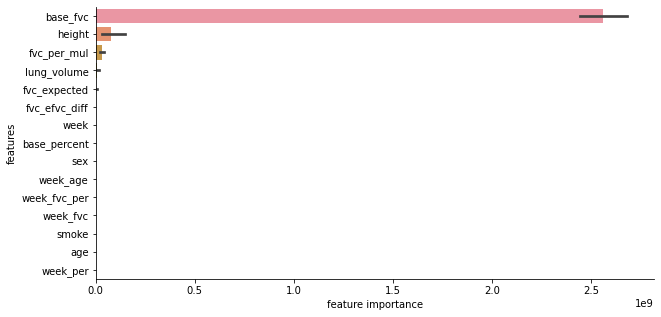

In [32]:
if exec_custom_loss:
    df_imp = lgbm_p1_c.plot_feature_importance()

In [33]:
if exec_regression:
    lgbm_p1 = LgbModel(train, sub, "FVC", FE,
                       valid_df=None, task="regression",
                       cv_method="GroupKFold", n_splits=5, group="Patient", 
                       params=None, parameter_tuning=True, verbose=False)    

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-10-09 15:20:48,991] Finished trial#0 with value: 257.5038757801801 with parameters: {'max_depth': 1, 'subsample': 0.4512238324057489, 'subsample_freq': 1, 'min_child_weight': 6, 'feature_fraction': 0.8317189996790773, 'bagging_fraction': 0.587245503583205, 'bagging_freq': 2, 'min_child_samples': 30, 'lambda_l1': 0.3622278000777448, 'lambda_l2': 0.12433294069391987}. Best is trial#0 with value: 257.5038757801801.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Fou

[I 2020-10-09 15:21:07,815] Finished trial#9 with value: 253.44772734210895 with parameters: {'max_depth': 1, 'subsample': 0.255423977689082, 'subsample_freq': 1, 'min_child_weight': 5, 'feature_fraction': 0.5952300477710246, 'bagging_fraction': 0.9841758796585978, 'bagging_freq': 6, 'min_child_samples': 74, 'lambda_l1': 0.0030382818130205674, 'lambda_l2': 3.664420552137315e-06}. Best is trial#8 with value: 253.1292703314625.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-10-09 15:21:09,843] Finished trial#10 with value: 251.08643253886447 with parameters: {'max_depth': 1, 'subsample': 0.3681116716953129, 'subsample_freq': 1

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-10-09 15:21:28,317] Finished trial#19 with value: 260.82551012752685 with parameters: {'max_depth': 1, 'subsample': 0.4151899087450017, 'subsample_freq': 1, 'min_child_weight': 1, 'feature_fraction': 0.8123579868626956, 'bagging_fraction': 0.4087303980913805, 'bagging_freq': 5, 'min_child_samples': 6, 'lambda_l1': 1.2966493529961648e-05, 'lambda_l2': 0.00015993327936460446}. Best is trial#14 with value: 250.8114752578764.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-10-09 15:21:50,482] Finished trial#29 with value: 252.26172124672283 with parameters: {'max_depth': 1, 'subsample': 0.4435066703688779, 'subsample_freq': 1, 'min_child_weight': 6, 'feature_fraction': 0.923538545483075, 'bagging_fraction': 0.952284011246437, 'bagging_freq': 2, 'min_child_samples': 32, 'lambda_l1': 3.600205929935904e-05, 'lambda_l2': 0.1126303683579983}. Best is trial#14 with value: 250.8114752578764.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Datas

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-10-09 15:22:11,753] Finished trial#39 with value: 264.45241456069505 with parameters: {'max_depth': 1, 'subsample': 0.36924075514548566, 'subsample_freq': 1, 'min_child_weight': 6, 'feature_fraction': 0.46085802478657023, 'bagging_fraction': 0.9229809629048172, 'bagging_freq': 3, 'min_child_samples': 83, 'lambda_l1': 0.0005778105914234352, 'lambda_l2': 1.7123774073239026e-07}. Best is trial#32 with value: 250.79705330210058.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-10-09 15:22:32,714] Finished trial#49 with value: 252.95823323076434 with parameters: {'max_depth': 1, 'subsample': 0.2724124923408466, 'subsample_freq': 1, 'min_child_weight': 6, 'feature_fraction': 0.9383633936945659, 'bagging_fraction': 0.7786119542316172, 'bagging_freq': 2, 'min_child_samples': 24, 'lambda_l1': 9.752360253133556e-05, 'lambda_l2': 1.765140918909467e-06}. Best is trial#40 with value: 250.29821372747418.


Number of finished trials: 50
Best trial:
  Value: 250.29821372747418
  Params: 
    max_depth: 1
    subsample: 0.26621022053976445
    subsample_freq: 1
    min_child_weight: 2
    feature_fraction: 0.9702300298611323
    bagging_fraction: 0.8667799212764508
    bagging_freq: 1
    min_child_samples: 38
    lambda_l1: 0.3646221415307905
    lambda_l2: 2.388413863341476e-06


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 0 is: 310.31576544097254


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 1 is: 288.9280573543022


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 2 is: 214.1279982841389


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 3 is: 378.35393539378254


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 4 is: 318.33303858638794
Our oof loss score is:  306.17053043029455


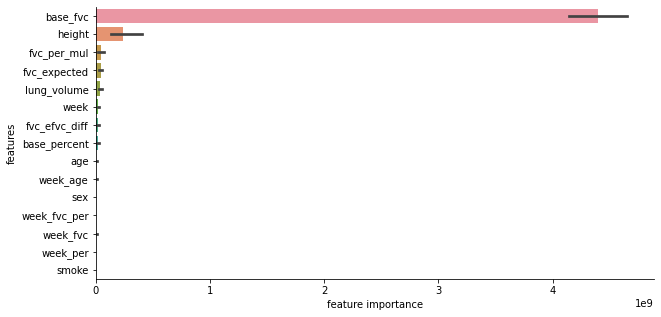

In [34]:
if exec_regression:
    df_imp = lgbm_p1.plot_feature_importance()

In [35]:
if exec_regression:
    lgbm_p0 = LgbModel(train, sub, "FVC", FE,
                       valid_df=None, task="quantile", alpha=0.25,
                       cv_method="GroupKFold", n_splits=5, group="Patient", 
                       params=None, parameter_tuning=True, verbose=False)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:22:48,224] Finished trial#0 with value: 395.76402566967573 with parameters: {'max_depth': 1, 'subsample': 0.44305841053572337, 'subsample_freq': 1, 'min_child_weight': 4, 'feature_fraction': 0.9934345332845694, 'bagging_fraction': 0.5569292410913779, 'bagging_freq': 1, 'min_child_samples': 27, 'lambda_l1': 0.017688872063529783, 'lambda_l2': 1.3835996267562067e-05}. Best is trial#0 with value: 395.76402566967573.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:22:50,411] Finis

[I 2020-10-09 15:23:11,350] Finished trial#11 with value: 390.9201661683369 with parameters: {'max_depth': 1, 'subsample': 0.49286388074919146, 'subsample_freq': 1, 'min_child_weight': 14, 'feature_fraction': 0.8287073072239484, 'bagging_fraction': 0.7966613347547689, 'bagging_freq': 5, 'min_child_samples': 14, 'lambda_l1': 0.035584467625826, 'lambda_l2': 1.2816326621106199e-08}. Best is trial#5 with value: 390.4016426413076.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:23:13,592] Finished trial#12 with value: 393.22978879566716 with parameters: {'max_depth': 1, 'subsample': 0.4646573762685428, 'subsample_freq': 1, 'min_child_weight': 14, 'feature_fraction': 0.6246826415782014, 'bagging_fraction': 0.8498579296819955, 'bagging_freq': 5, 'min_child_samp

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:23:37,270] Finished trial#23 with value: 369.6460363514549 with parameters: {'max_depth': 1, 'subsample': 0.2905735656850804, 'subsample_freq': 1, 'min_child_weight': 11, 'feature_fraction': 0.9097170636013765, 'bagging_fraction': 0.9981779465806802, 'bagging_freq': 1, 'min_child_samples': 18, 'lambda_l1': 8.982409036750921e-07, 'lambda_l2': 0.09735207616697002}. Best is trial#21 with value: 367.07750422288933.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:23:39,535] Finished trial#24 with value: 378.262259395467 with parameters: {'max_depth': 1, 'subsample': 0.23988242147021413, 'subsample_freq': 1, 'min_child_weight': 1

[I 2020-10-09 15:24:00,538] Finished trial#34 with value: 374.58899390831715 with parameters: {'max_depth': 1, 'subsample': 0.25339723720714974, 'subsample_freq': 1, 'min_child_weight': 3, 'feature_fraction': 0.9089280905266729, 'bagging_fraction': 0.9983367129112706, 'bagging_freq': 2, 'min_child_samples': 28, 'lambda_l1': 6.160178876906277e-08, 'lambda_l2': 0.16248532902832605}. Best is trial#21 with value: 367.07750422288933.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:24:02,619] Finished trial#35 with value: 386.6516492266007 with parameters: {'max_depth': 1, 'subsample': 0.3002305271348031, 'subsample_freq': 1, 'min_child_weight': 5, 'feature_fraction': 0.8548759291869378, 'bagging_fraction': 0.8982014216819363, 'bagging_freq': 1, 'min_child_sam

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:24:25,795] Finished trial#46 with value: 376.73667945209434 with parameters: {'max_depth': 1, 'subsample': 0.32453749222973055, 'subsample_freq': 1, 'min_child_weight': 12, 'feature_fraction': 0.851741168626975, 'bagging_fraction': 0.9477398772636888, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 4.2254236464196015e-07, 'lambda_l2': 2.2549593999684876}. Best is trial#21 with value: 367.07750422288933.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:24:27,843] Finished trial#47 with value: 389.50789445078146 with parameters: {'max_depth': 1, 'subsample': 0.3464124485610808, 'subsample_freq': 1, 'min_child_weight':

Number of finished trials: 50
Best trial:
  Value: 367.07750422288933
  Params: 
    max_depth: 1
    subsample: 0.2851418731272785
    subsample_freq: 1
    min_child_weight: 7
    feature_fraction: 0.9274406865553162
    bagging_fraction: 0.9971080993845375
    bagging_freq: 2
    min_child_samples: 20
    lambda_l1: 4.423634219312919e-06
    lambda_l2: 0.003307164383451468


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 0 is: 334.5030356269925


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 1 is: 273.1361847513787


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 2 is: 238.0665370454041


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 3 is: 423.9755805880268


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 4 is: 325.2746068110636
Our oof loss score is:  324.53150614303115


In [36]:
if exec_regression:
    lgbm_p2 = LgbModel(train, sub, "FVC", FE,
                       valid_df=None, task="quantile", alpha=0.75,
                       cv_method="GroupKFold", n_splits=5, group="Patient", 
                       params=None, parameter_tuning=True, verbose=False)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:24:47,170] Finished trial#0 with value: 338.2877510640043 with parameters: {'max_depth': 1, 'subsample': 0.36060379574480883, 'subsample_freq': 1, 'min_child_weight': 6, 'feature_fraction': 0.8888683176837355, 'bagging_fraction': 0.7991587251272894, 'bagging_freq': 2, 'min_child_samples': 50, 'lambda_l1': 2.7182904699404684, 'lambda_l2': 3.5906096682879115e-08}. Best is trial#0 with value: 338.2877510640043.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:24:49,182] Finished 

[I 2020-10-09 15:25:09,701] Finished trial#11 with value: 341.8924840654252 with parameters: {'max_depth': 1, 'subsample': 0.318138746790747, 'subsample_freq': 1, 'min_child_weight': 5, 'feature_fraction': 0.9538030673525287, 'bagging_fraction': 0.6410166491064847, 'bagging_freq': 3, 'min_child_samples': 40, 'lambda_l1': 2.491590984428234, 'lambda_l2': 0.00013064665639723973}. Best is trial#2 with value: 335.9688844943535.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:25:11,794] Finished trial#12 with value: 340.13482798042224 with parameters: {'max_depth': 1, 'subsample': 0.43501134824917087, 'subsample_freq': 1, 'min_child_weight': 17, 'feature_fraction': 0.8085804559543235, 'bagging_fraction': 0.9935399468369344, 'bagging_freq': 5, 'min_child_sample

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:25:35,894] Finished trial#23 with value: 337.7232181068864 with parameters: {'max_depth': 1, 'subsample': 0.4159854277594181, 'subsample_freq': 1, 'min_child_weight': 15, 'feature_fraction': 0.9271353200359315, 'bagging_fraction': 0.7225154487873165, 'bagging_freq': 7, 'min_child_samples': 84, 'lambda_l1': 0.0011225135039995046, 'lambda_l2': 5.403048325400455e-07}. Best is trial#19 with value: 335.70905067704024.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:25:37,941] Finished trial#24 with value: 337.6858990839003 with parameters: {'max_depth': 1, 'subsample': 0.4349815690002429, 'subsample_freq': 1, 'min_child_weight':

[I 2020-10-09 15:25:58,969] Finished trial#34 with value: 330.5829284759493 with parameters: {'max_depth': 1, 'subsample': 0.3249633163438757, 'subsample_freq': 1, 'min_child_weight': 18, 'feature_fraction': 0.9998971940723689, 'bagging_fraction': 0.9932801700062417, 'bagging_freq': 6, 'min_child_samples': 68, 'lambda_l1': 0.00024226867854549203, 'lambda_l2': 2.3154665415083356e-06}. Best is trial#28 with value: 329.8671802154783.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:26:00,998] Finished trial#35 with value: 330.7993266435297 with parameters: {'max_depth': 1, 'subsample': 0.31789607281335247, 'subsample_freq': 1, 'min_child_weight': 20, 'feature_fraction': 0.9991410611696314, 'bagging_fraction': 0.9995723201016916, 'bagging_freq': 6, 'min_child

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:26:24,215] Finished trial#46 with value: 341.3418854321432 with parameters: {'max_depth': 1, 'subsample': 0.3566938362526983, 'subsample_freq': 1, 'min_child_weight': 13, 'feature_fraction': 0.912639965017655, 'bagging_fraction': 0.9481378149659452, 'bagging_freq': 7, 'min_child_samples': 82, 'lambda_l1': 6.361326739593345e-05, 'lambda_l2': 2.987548905823124e-08}. Best is trial#28 with value: 329.8671802154783.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-09 15:26:26,284] Finished trial#47 with value: 358.1704255187501 with parameters: {'max_depth': 1, 'subsample': 0.31940697664316764, 'subsample_freq': 1, 'min_child_weight': 

Number of finished trials: 50
Best trial:
  Value: 329.8671802154783
  Params: 
    max_depth: 1
    subsample: 0.3304379249652198
    subsample_freq: 1
    min_child_weight: 19
    feature_fraction: 0.9967806645754144
    bagging_fraction: 0.9965956345992791
    bagging_freq: 5
    min_child_samples: 90
    lambda_l1: 0.0016225302521293385
    lambda_l2: 2.400967873426166e-07


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 0 is: 332.737554250556


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 1 is: 331.77652553678803


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 2 is: 297.6564460018861


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 3 is: 441.4071766606386


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 4 is: 368.0914926324254
Our oof loss score is:  357.15504851423395


In [37]:
def change_values(idx, ary):
    tmp_min = ary[idx].min()
    tmp_med = np.median(ary[idx])
    tmp_max = ary[idx].max()
    ary[idx,0] = tmp_min
    ary[idx,1] = tmp_med
    ary[idx,2] = tmp_max
    print("pred_lgbm", ary[idx])
    return ary

if exec_regression:
    pred_lgbm = np.hstack([lgbm_p0.oof,    lgbm_p1.oof,    lgbm_p2.oof])
    pe_lgbm   = np.hstack([lgbm_p0.y_pred, lgbm_p1.y_pred, lgbm_p2.y_pred])

    for idx in np.where((pred_lgbm[:,2]-pred_lgbm[:,0])<0)[0]:
        pred_lgbm = change_values(idx, pred_lgbm)
    for idx in np.where((pe_lgbm[:,2]-pe_lgbm[:,0])<0)[0]:
        pe_lgbm   = change_values(idx, pe_lgbm)
        
if exec_custom_loss:
    pred_lgbm_c = np.vstack([lgbm_p1_c.oof[:,0]-(lgbm_p1_c.oof[:,1]/2),
                             lgbm_p1_c.oof[:,0],
                             lgbm_p1_c.oof[:,0]+(lgbm_p1_c.oof[:,1]/2)]).T
    pe_lgbm_c   = np.vstack([lgbm_p1_c.y_pred[:,0]-(lgbm_p1_c.y_pred[:,1]/2),
                             lgbm_p1_c.y_pred[:,0],
                             lgbm_p1_c.y_pred[:,0]+(lgbm_p1_c.y_pred[:,1]/2)]).T

In [38]:
emsambles = []

if exec_regression and exec_custom_loss:
    for a in np.arange(0,1.1,0.1):
        a = round(a,1)
        a_max = 1-a
        for b in np.arange(0,a_max+0.1,0.1):
            b = round(b,1)
            c = round((a_max-b),1)
            emsambled  = a*pred_lgbm + b*pred_lgbm_c + c*pred
            last3_pred = emsambled[np.where(emsambled.sum(1))]
            last3_fvc  = train.query("last3").FVC
            lll = calculate_scores(last3_fvc, last3_pred, True, False)
            emsambles.append([a,b,c,lll])
    df_result_pred = pd.DataFrame(emsambles, columns=["a","b","c","lll"])
    a,b,c = df_result_pred.sort_values(by="lll", ascending=False).iloc[0,:3]
    best_pred = a*pred_lgbm + b*pred_lgbm_c + c*pred
    print("Best emsamble parameters are %s,%s,%s" % (a,b,c))

else:
    for a in np.arange(0,1.1,0.1):
        a = round(a,1)
        print(a)
        emsambled  = a*pred_lgbm + (1-a)*pred if exec_regression else a*pred_lgbm_c + (1-a)*pred
        last3_pred = emsambled[np.where(emsambled.sum(1))]
        last3_fvc  = train.query("last3").FVC
        lll = calculate_scores(last3_fvc, last3_pred, True)
        emsambles.append([a,lll])
    
    a = emsambles[np.argmax(np.array(emsambles)[:,1])][0]
    best_pred = a*pred_lgbm + (1-a)*pred if exec_regression else a*pred_lgbm_c + (1-a)*pred
    print("Best emsamble parameter is %s" % a)

Best emsamble parameters are 0.2,0.1,0.7


In [39]:
last3_pred = best_pred[np.where(best_pred.sum(1))]
last3_fvc  = train.query("last3").FVC
calculate_scores(last3_fvc, last3_pred)

Laplace log likelihood -6.990719807996815
mean_absolute_error 198.7352399163338
uncertainty 273.0105003491399 128.8537869694528 560.4758503844059


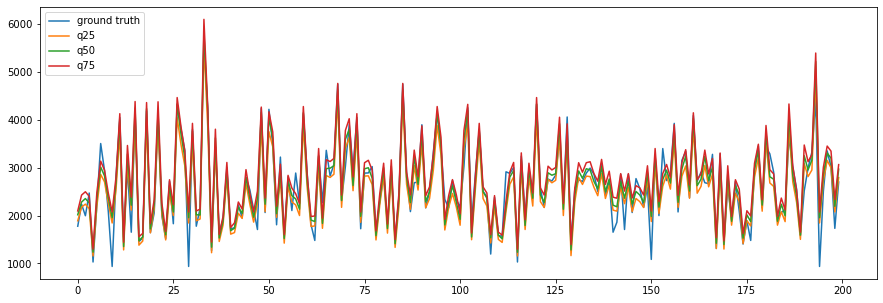

In [40]:
plt.figure(figsize=(15,5))
idxs = np.random.randint(0, last3_pred.shape[0], 200)
plt.plot(last3_fvc.values[idxs], label="ground truth")
plt.plot(last3_pred[idxs, 0], label="q25")
plt.plot(last3_pred[idxs, 1], label="q50")
plt.plot(last3_pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

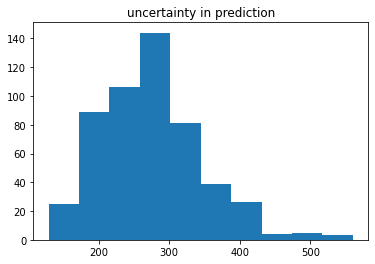

In [41]:
plt.hist(last3_pred[:, 2]-last3_pred[:, 0])
plt.title("uncertainty in prediction")
plt.show()

In [42]:
# PREDICTION
if exec_regression and exec_custom_loss:
    sub['FVC1']        = a*pe_lgbm[:, 1] + b*pe_lgbm_c[:, 1] + c*pe[:, 1]
    sub['Confidence1'] = a*(pe_lgbm[:, 2] - pe_lgbm[:, 0]) + b*(pe_lgbm_c[:, 2] - pe_lgbm_c[:, 0]) + c*(pe[:, 2] - pe[:, 0])
elif exec_regression:
    sub['FVC1']        = a*pe_lgbm[:, 1] + (1-a)*pe[:, 1]
    sub['Confidence1'] = a*(pe_lgbm[:, 2] - pe_lgbm[:, 0]) + (1-a)*(pe[:, 2] - pe[:, 0])
else:
    sub['FVC1']        = a*pe_lgbm_c[:, 1] + (1-a)*pe[:, 1]
    sub['Confidence1'] = a*(pe_lgbm_c[:, 2] - pe_lgbm_c[:, 0]) + (1-a)*(pe[:, 2] - pe[:, 0])

subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [43]:
display(subm.head())
subm[["FVC","Confidence"]].describe().T

,Patient_Week,FVC,Confidence,FVC1,Confidence1
0,ID00419637202311204720264_-12,2979.961295,264.573050,2979.961295,264.573050
1,ID00419637202311204720264_-11,2977.302201,264.577750,2977.302201,264.577750
2,ID00419637202311204720264_-10,2974.643064,264.582449,2974.643064,264.582449
3,ID00419637202311204720264_-9,2971.984013,263.784352,2971.984013,263.784352
4,ID00419637202311204720264_-8,2968.573733,266.744881,2968.573733,266.744881


,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2588.452577,426.978074,1711.054341,2508.974754,2695.084646,2874.378517,3241.775063
Confidence,730.0,274.850756,46.058048,175.247571,269.028180,282.305341,309.199318,335.018828


In [44]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [45]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

# Ensemble (Simple Blend)

In [46]:
if USE_ALL:
    emsambles = []
    for a in np.arange(0,1.1,0.05):
        a = round(a,2)
        emsambled = a*last3_pred_img + (1-a)*last3_pred
        lll = calculate_scores(last3_fvc, emsambled, True, False)
        emsambles.append([a,lll])
    best_a = emsambles[np.argmax(np.array(emsambles)[:,1])][0]
    best_pred = best_a*last3_pred_img + (1-best_a)*last3_pred
    print("Best emsamble parameter is %s" % best_a)
    calculate_scores(last3_fvc, best_pred, show=True)
else:
    best_a = 0.3

Best emsamble parameter is 0.3
Laplace log likelihood -6.978509790641236
mean_absolute_error 196.9264762999061
uncertainty 255.90750260430045 122.5742898904125 497.8485069470544


In [47]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [48]:
df = df1[['Patient_Week']].copy()
df['FVC']        = best_a*df1['FVC']        + (1-best_a)*df2['FVC']
df['Confidence'] = best_a*df1['Confidence'] + (1-best_a)*df2['Confidence']
print(df.shape)
sample_submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
submission = sample_submission[["Patient_Week"]].merge(df, on="Patient_Week")
print(submission.shape)
submission.head()

(730, 3)
(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3011.152583,225.436868
1,ID00421637202311550012437_-12,2775.956377,250.807289
2,ID00422637202311677017371_-12,1973.392751,165.437244
3,ID00423637202312137826377_-12,3288.327969,268.171870
4,ID00426637202313170790466_-12,2900.414867,217.813032


In [49]:
submission.to_csv('submission.csv', index=False)